# Importing Necessary Libraries:

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras import metrics
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers.core import Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers.merge import concatenate, add
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight


import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np

import cv2
import nibabel as nib
from PIL import Image
import tensorflow 
import tensorflow.keras as keras

import skimage.io

In [2]:
!pip install SimpleITK
import SimpleITK

     |████████████████████████████████| 48.4 MB 56 kB/s 


# Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip /content/gdrive/MyDrive/BRATS_data.zip

Archive:  /content/gdrive/MyDrive/BRATS_data.zip
   creating: MICCAI_BraTS_2018_Data_Training/
   creating: MICCAI_BraTS_2018_Data_Training/LGG/
   creating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_0_1/
  inflating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_0_1/Brats18_2013_0_1_flair.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_0_1/Brats18_2013_0_1_seg.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_0_1/Brats18_2013_0_1_t1.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_0_1/Brats18_2013_0_1_t1ce.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_0_1/Brats18_2013_0_1_t2.nii  
   creating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_15_1/
  inflating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_15_1/Brats18_2013_15_1_flair.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_15_1/Brats18_2013_15_1_seg.nii  
  inflating: MICCAI_BraTS_2018_Data_Training/LGG/Brats18_2013_

# Path to training images

In [5]:
path="/content/MICCAI_BraTS_2018_Data_Training/HGG/"


# All folders in our data

In [6]:
ids=next(os.walk(path))[1]
print(ids)


['Brats18_2013_21_1', 'Brats18_TCIA02_283_1', 'Brats18_CBICA_ATP_1', 'Brats18_TCIA04_192_1', 'Brats18_2013_4_1', 'Brats18_TCIA01_335_1', 'Brats18_2013_20_1', 'Brats18_TCIA04_111_1', 'Brats18_2013_26_1', 'Brats18_TCIA08_205_1', 'Brats18_TCIA01_411_1', 'Brats18_2013_19_1', 'Brats18_CBICA_ATV_1', 'Brats18_TCIA03_296_1', 'Brats18_2013_11_1', 'Brats18_CBICA_AUR_1', 'Brats18_CBICA_ABO_1', 'Brats18_TCIA03_338_1', 'Brats18_TCIA02_368_1', 'Brats18_CBICA_ATB_1', 'Brats18_TCIA08_242_1', 'Brats18_CBICA_ASK_1', 'Brats18_TCIA03_133_1', 'Brats18_2013_10_1', 'Brats18_TCIA02_374_1', 'Brats18_TCIA02_171_1', 'Brats18_2013_12_1', 'Brats18_TCIA01_131_1', 'Brats18_2013_7_1', 'Brats18_TCIA01_412_1', 'Brats18_TCIA06_409_1', 'Brats18_CBICA_BHM_1', 'Brats18_CBICA_AQV_1', 'Brats18_TCIA06_247_1', 'Brats18_TCIA01_499_1', 'Brats18_TCIA02_222_1', 'Brats18_2013_18_1', 'Brats18_TCIA02_322_1', 'Brats18_TCIA01_448_1', 'Brats18_CBICA_AUN_1', 'Brats18_TCIA08_436_1', 'Brats18_TCIA03_375_1', 'Brats18_CBICA_AQP_1', 'Brats18_

In [7]:
len(ids)

210

# Function to standardize images

In [8]:
def standardize(image):

    standardized_image = np.zeros(image.shape)

    
   
        # iterate over the `z` dimension
    for z in range(image.shape[2]):
        # get a slice of the image at z-th dimension `z`
        image_slice = image[:,:,z]

        # subtract the mean from image_slice
        centered = image_slice - np.mean(image_slice)
       
        # divide by the standard deviation (only if it is different from zero)
        if(np.std(centered)!=0):
            centered = centered/np.std(centered)

        # update  the slice of standardized image
        standardized_image[:, :,z] = centered


    return standardized_image

# Convolution block

In [9]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
  
  return X

# UNet 3D Architecture:

In [10]:
def Unet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  c1 = conv_block(input_img,n_filters,3,batch_norm)
  p1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv_block(p1,n_filters*2,3,batch_norm);
  p2 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_block(p2,n_filters*4,3,batch_norm);
  p3 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3,n_filters*8,3,batch_norm);
  p4 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv_block(p4,n_filters*16,3,batch_norm);

  u6 = Conv3DTranspose(n_filters*8, (3,3,3), strides=(2, 2, 2), padding='same')(c5);
  u6 = concatenate([u6,c4]);
  c6 = conv_block(u6,n_filters*8,3,batch_norm)
  c6 = Dropout(dropout)(c6)
  u7 = Conv3DTranspose(n_filters*4,(3,3,3),strides = (2,2,2) , padding= 'same')(c6);

  u7 = concatenate([u7,c3]);
  c7 = conv_block(u7,n_filters*4,3,batch_norm)
  c7 = Dropout(dropout)(c7)
  u8 = Conv3DTranspose(n_filters*2,(3,3,3),strides = (2,2,2) , padding='same')(c7);
  u8 = concatenate([u8,c2]);

  c8 = conv_block(u8,n_filters*2,3,batch_norm)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters,(3,3,3),strides = (2,2,2) , padding='same')(c8);

  u9 = concatenate([u9,c1]);

  c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1, 1,1), activation='softmax')(c9)
  print("!!!!!!!!!!!!!!!!!!!")
  print(outputs.shape)
  model = Model(inputs=input_img, outputs=outputs)

  return model


# Dice Co-efficient and Dice-Loss

In [11]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


In [12]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Preparing the model:

In [13]:
from tensorflow.keras.optimizers import RMSprop

In [14]:
input_img = Input((128,128,128,4))
model = Unet_3d(input_img,8,0.1,True)
learning_rate = 0.01
decay_rate = 0.000001
model.compile(optimizer=Adam(lr=learning_rate, decay = decay_rate), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

!!!!!!!!!!!!!!!!!!!
(None, 128, 128, 128, 4)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 872         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 128 32          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 128 0           batch_normalization[0][0]        
_________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
import tensorflow.keras as keras
import tensorflow


In [16]:
all_images=os.listdir(path)

# Number of images used:

In [17]:
nou=180 #Number of images used 

In [18]:
# This function resizes 3d images
def my_resize_func(img):
    out_im=[]
    for i in range(15,143):
        im1=img[:,:,i]
        im1=cv2.resize(im1,(128,128))
        out_im.append(im1)
    return np.array(out_im,np.float32)


# A sample image:

In [19]:
path1=path+all_images[2]
path1
m=os.listdir(path1)
t=path1+"/"+m[3]
t



'/content/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_CBICA_ATP_1/Brats18_CBICA_ATP_1_t1.nii'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


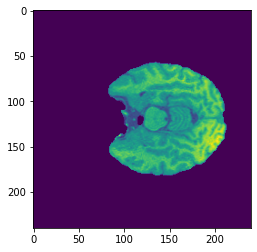

In [20]:
imm=nib.load(t)
imm2=imm.get_data()
imm2=standardize(imm2)
plt.imshow(imm2[:,:,50])

# Preparing the train images and training:

In [21]:
loss=[]
acc=[]
for epochs in range(50):
    loss1=[]
    acc1=[]
    # data preprocessing starts here
    for image_num in range(180):
        y_train=[]
        flair=[]
        t1=[]
        t2=[]
        t1ce=[]
        data=np.zeros((240,240,155,4))
        x = all_images[image_num]
        print(x)
        folder_path = path+x;
        modalities = os.listdir(folder_path)
        modalities.sort()
        #data = []
        
        for j in range(len(modalities)):

            #print(modalities[j])
            
            image_path = folder_path + '/' + modalities[j]
            if (image_path[-7:-1] + image_path[-1] == 'seg.nii'): #Prepares the ground truth

                img = nib.load(image_path)
                image_data2 = img.get_data()
                image_data2 = np.asarray(image_data2,np.float32)
                #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
                y_train=image_data2
                
            if (image_path[-9:-1] + image_path[-1] == 'flair.nii'): #Prepares the Flair modality

                img = nib.load(image_path)
                image_data2 = img.get_data()
                image_data2 = np.asarray(image_data2,np.float32)
                #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
                image_data2=standardize(image_data2)
                data[:,:,:,0]=image_data2
            if (image_path[-6:-1] + image_path[-1] == 't1.nii'): #Prepares the t1 modality

                img = nib.load(image_path)
                image_data2 = img.get_data()
                image_data2 = np.asarray(image_data2,np.float32)
                #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
                image_data2=standardize(image_data2)
                data[:,:,:,1]=image_data2
            if (image_path[-6:-1] + image_path[-1] == 't2.nii'): # Prepares the t2 modality

                img = nib.load(image_path);
                image_data2 = img.get_data()
                image_data2 = np.asarray(image_data2,np.float32)
                #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
                image_data2=standardize(image_data2)
                data[:,:,:,2]=image_data2
        
            if (image_path[-8:-1] + image_path[-1] == 't1ce.nii'): #Prepares the t1ce modality

                img = nib.load(image_path)
                image_data2 = img.get_data()
                image_data2 = np.asarray(image_data2,np.float32)
                #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
                image_data2=standardize(image_data2)
                data[:,:,:,3]=image_data2

            
        
        y_train=y_train[60:188,60:188,15:143]
        y_train=y_train.reshape((1,128,128,128))
        print(y_train.shape)

        y_train[y_train==4]=3

        #flair=np.array(flair,np.float32)
        #flair=flair[:,60:188,60:188,15:143]
        #print(flair.shape)

        #t1=np.array(t1,np.float32)
        #t1=t1[:,60:188,60:188,15:143]
        #print(t1.shape)

        #t1ce=np.array(t1ce,np.float32)
        #t1ce=t1ce[:,60:188,60:188,15:143]
        #print(t1ce.shape)

        #t2=np.array(t2,np.float32)
        #t2=t2[:,60:188,60:188,15:143]
        #print(t2.shape)

        x_train=data[60:188,60:188,15:143,:]
        print(x_train.shape)
        x_train=x_train.reshape((1,128,128,128,4))
        print(x_train.shape)


        hello = y_train.flatten()
        #y_to = keras.utils.to_categorical(y_to,num_classes=2)
        print(y_train.shape)
        #print(hello[hello==3].shape)
        print("Number of classes",np.unique(hello))
        class_weights = class_weight.compute_class_weight('balanced',np.unique(hello),hello)
        print(class_weights)

        y_train = to_categorical(y_train, num_classes = 4)


        hist=model.fit(x_train,y_train,epochs=1)
        loss1.append(hist.history["loss"])
        acc1.append(hist.history["dice_coef"])
    loss.append(np.mean(loss1))
    acc.append(np.mean(acc1))  




        

        

Brats18_2013_21_1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.datao

Streaming output truncated to the last 5000 lines.
(1, 128, 128, 128)
(128, 128, 128, 4)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
Number of classes [0. 1. 2. 3.]
[ 0.27389305  7.26261255  6.32403744 18.82474597]
1/1 [==============================] - 1s 610ms/step - loss: 0.1995 - dice_coef: 0.8005
Brats18_TCIA02_455_1
(1, 128, 128, 128)
(128, 128, 128, 4)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
Number of classes [0. 1. 2. 3.]
[ 0.26214177 81.907202    7.64167966 23.69663277]
1/1 [==============================] - 1s 627ms/step - loss: 0.0750 - dice_coef: 0.9250
Brats18_TCIA03_419_1
(1, 128, 128, 128)
(128, 128, 128, 4)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
Number of classes [0. 1. 2. 3.]
[ 0.26898675 14.84141992  9.65753021  8.97507532]
1/1 [==============================] - 1s 619ms/step - loss: 0.0869 - dice_coef: 0.9131
Brats18_TCIA08_234_1
(1, 128, 128, 128)
(128, 128, 128, 4)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
Number of classes [0. 1. 2. 3.]
[2.60125556e-01 3.44246881e+

In [23]:
model.save('/content/gdrive/MyDrive/working models brats 18/3d_model1.h5')

# Testing:

In [35]:
x = all_images[208]
print("Testing on image number 201")
folder_path = path + '/' + x;
modalities = os.listdir(folder_path)
modalities.sort()
data = np.zeros((240,240,155,4))
#data = []
w = 0
for j in range(len(modalities)):
  #print(modalities[j])

  image_path = folder_path + '/' + modalities[j]
  if not(image_path.find('seg.nii') == -1):
    img = nib.load(image_path);
    image_data2 = img.get_data()
    image_data2 = np.asarray(image_data2)
    print("Entered ground truth")
  else:
    img = nib.load(image_path);
    image_data = img.get_data()
    image_data = np.asarray(image_data)
    image_data = standardize(image_data)
    data[:,:,:,w] = image_data
    print("Entered modality")
    w = w+1

print(data.shape)
print(image_data2.shape)

Testing on image number 201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Entered modality
Entered ground truth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app


Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)


# Preparing the test data:

In [36]:
x_test=data[60:188,60:188,15:143,:]
print(x_test.shape)
x_test=x_test.reshape((1,128,128,128,4))
print(x_test.shape)



(128, 128, 128, 4)
(1, 128, 128, 128, 4)


# Preparing the ground truth:

In [37]:
y_test=image_data2[60:188,60:188,15:143]
y_test=y_test.reshape((1,128,128,128))
print(y_test.shape)

y_test[y_test==4]=3


(1, 128, 128, 128)


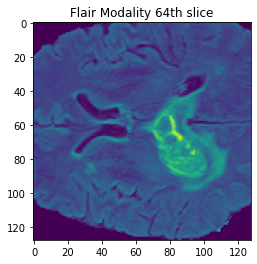

In [38]:
Y_hat = model.predict(x=x_test)
Y_hat = np.argmax(Y_hat,axis=-1)
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
img = x_test[0,:,:,64,0]
imgplot = plt.imshow(img)
plt.title('Flair Modality 64th slice')
plt.savefig('Flair')
plt.show()

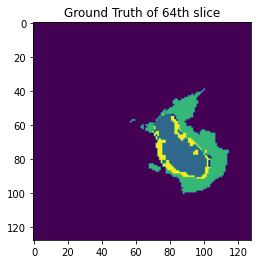

In [39]:
img2 = y_test[0,:,:,64]
imgplot2 = plt.imshow(img2)
plt.title('Ground Truth of 64th slice')
plt.savefig('Ground_Truth')
plt.show()

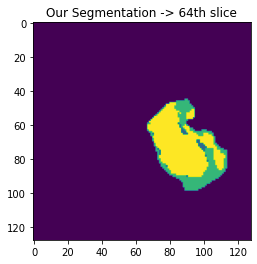

In [40]:
img3 = Y_hat[0,:,:,64]
imgplot3 = plt.imshow(img3)
plt.title('Our Segmentation -> 64th slice')
plt.savefig('Our Segmentation')
plt.show()


In [31]:
loss

[0.46708077788352964,
 0.3477807968854904,
 0.3151135673125585,
 0.29589999384350246,
 0.2885077125496335,
 0.27581540511714087,
 0.26570234696070355,
 0.2641730096605089,
 0.2534476614660687,
 0.2422910491625468,
 0.2414937784274419,
 0.23847941391997868,
 0.22813225653436447,
 0.2255234870645735,
 0.222491607732243,
 0.23145948648452758,
 0.21726987693044875,
 0.21036940150790745,
 0.20858007073402404,
 0.20868994726075066,
 0.20514213939507803,
 0.202722297112147,
 0.20110551284419165,
 0.19994405971633064,
 0.19678955177466076,
 0.18787479367521073,
 0.186429030696551,
 0.18932732939720154,
 0.1842259274588691,
 0.18091245790322621,
 0.18366441859139337,
 0.1794794393910302,
 0.17863348854912653,
 0.17492119934823777,
 0.17390419277879926,
 0.17280887630250719,
 0.1688711080286238,
 0.1721819003423055,
 0.16769230630662707,
 0.16893214252259997,
 0.16662803358501857,
 0.16582385202248892,
 0.16683747735288407,
 0.1609090010325114,
 0.16094782021310594,
 0.1590706533855862,
 0.15963

In [32]:
acc

[0.5329192230270968,
 0.6522192031145095,
 0.6848864323563046,
 0.704100005990929,
 0.7114922872847981,
 0.7241845942205853,
 0.7342976527081595,
 0.7358269901739226,
 0.7465523388650682,
 0.7577089516652955,
 0.758506221903695,
 0.7615205857488844,
 0.771867743300067,
 0.7744765127698581,
 0.7775083924333255,
 0.7685405133499039,
 0.7827301232351197,
 0.789630598326524,
 0.7914199292659759,
 0.7913100527392494,
 0.7948578604393535,
 0.7972777030534215,
 0.7988944869902399,
 0.8000559402836693,
 0.8032104480597708,
 0.8121252066559261,
 0.8135709694690174,
 0.81067267043723,
 0.8157740723755624,
 0.8190875420967738,
 0.8163355814086066,
 0.8205205606089698,
 0.8213665116164419,
 0.8250788008173306,
 0.8260958073867692,
 0.8271911236974928,
 0.8311288919713762,
 0.8278180996576945,
 0.8323076935278044,
 0.8310678574774001,
 0.8333719664149815,
 0.834176147977511,
 0.8331625226471159,
 0.8390909992986255,
 0.8390521797868941,
 0.8409293466144138,
 0.8403606384992599,
 0.8428296264674928,

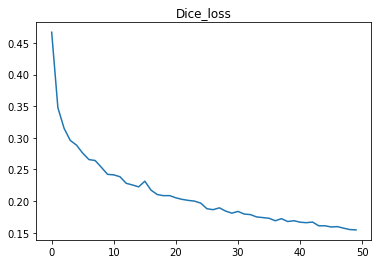

In [33]:
plt.plot(loss)
plt.title("Dice_loss")
plt.show()

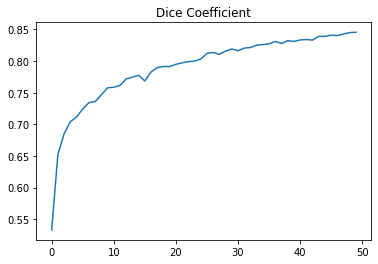

In [34]:
plt.plot(acc)
plt.title("Dice Coefficient")
plt.show()